# Predicting Kickstarter Success Likelihoods

The following is data exploration and modeling of kickstarter project success likelihoods. 

Team members: Kevin Velasco & Sherry Yang

## Business Background 

As of April 2019, $4.2bn has been crowdfunded for projects through Kickstarter. The platform has a 36.84 percent success rate for projects with “games” as the most popular project category. (Statista) 

We are offering a beta model that can produce a likelihood estimation for whether a project will be successful on Kickstarter. To create our first model, we used a dataset from Kaggle (https://www.kaggle.com/kemical/kickstarter-projects) which contains basic project data collected in 2016 and 2018. 

In future improved versions of this model, we would want to: 
* Incorporate data on marketing tactics and existing network connections that project owners have at the start of a campaign to better measure likelihood of success. 
* Incorporate data on the types of individuals who fund successful kickstarter campaigns - what are their demographics - and using that as an assessment of whether a project’s audience will match kickstarter’s audience

## Data Exploration: using the 2016 data set

We first took a look at the 2016 data set. We concluded that there were many errors in the data set and it would be better to use the 2018 data set. 

In [ ]:
import pandas as pd

In [ ]:
def get_lines():
    with open('kickstarter-projects/ks-projects-201612.csv', 'rb') as f:
        for line in f: 
            yield line

In [ ]:
def get_weird_lines():
    for i, line in enumerate(get_lines()):
        for char in line: 
            if char > 127:
                yield line

In [ ]:
weird_lines = get_weird_lines()

In [ ]:
next(weird_lines)

In [ ]:
line = next(weird_lines)[1]


In [ ]:
df_2016 = pd.read_csv('kickstarter-projects/ks-projects-201612.csv', encoding ='iso-8859-1')

In [ ]:
df_2016.columns

In [ ]:
df_2016 = df_2016.drop(['Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16'], axis=1)

In [ ]:
df_2016 = df_2016.rename(columns={'ID ': 'ID', 'name ': 'name', 'category ': 'category', 
                        'main_category ': 'main_category', 'currency ': 'currency',
                        'deadline ': 'deadline', 'goal ': 'goal', 'launched ': 'launched',
                        'pledged ': 'pledged', 'state ': 'state', 'backers ': 'backers',
                        'country ': 'country', 'usd pledged ':'usd_pledged'})

In [ ]:
df_2016_all = df_2016.loc[(df_2016['state'] == 'failed') | 
                      (df_2016['state'] == 'canceled') | 
                      (df_2016['state'] == 'successful') | 
                      (df_2016['state'] == 'live') | 
                      (df_2016['state'] == 'suspended') | 
                      (df_2016['state'] == 'undefined')]

#The 2016 data set is very unreliable across the dataframe

## Data exploration: Using the 2018 data set 
Importing Libraries

In [2]:
import collections
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from IPython.display import Image  
from sklearn import tree
#import pydotplus
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
df_2018 = pd.read_csv('kickstarter-projects/ks-projects-201801.csv', encoding ='iso-8859-1')

In [5]:
df_2018.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [6]:
df_2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


We made a decision given our business case to drop projects that were still in progress because we do not have a final outcome label. We dropped data on projects that were canceled or suspended because the reasons these projects didn't meet their goal were different than the reasons projects we want to predict were succeeding or falling short of funding goals.  

In [6]:
#Detects the live in state and drops them 
df_2018 = df_2018.loc[df_2018['state']!='live']

#Detects the undefined in state and drops them 
df_2018 = df_2018.loc[df_2018['state']!='undefined']

#Detects the undefined in state and drops them 
df_2018 = df_2018.loc[df_2018['state']!='canceled']

#Detects the undefined in state and drops them 
df_2018 = df_2018.loc[df_2018['state']!='suspended']

#Detects the undefined in usd pledged and drops them 
df_2018 = df_2018.loc[~df_2018['usd pledged'].isna(), :]

#Detects the undefined in usd pledged and drops them 
df_2018 = df_2018.loc[~df_2018['name'].isna(), :]

#### A look at successes and failures by main category

In [9]:
df_2018.category.value_counts()

Product Design       18679
Documentary          14523
Music                12485
Tabletop Games       11744
Shorts               11394
Food                 10416
Video Games           9327
Film & Video          8601
Fiction               8108
Fashion               7529
Art                   7486
Nonfiction            7414
Theater               6684
Rock                  6246
Children's Books      6198
Apparel               6165
Technology            5723
Indie Rock            5329
Apps                  5287
Photography           5246
Webseries             5148
Publishing            5020
Narrative Film        4617
Comics                4581
Web                   4309
Country & Folk        4213
Crafts                4152
Design                3547
Hip-Hop               3459
Hardware              3114
                     ...  
Blues                  234
Animals                229
Couture                227
Fabrication Tools      215
Makerspaces            208
Movie Theaters         201
P

In [10]:
df_2018['main_category'].unique()

array(['Publishing', 'Film & Video', 'Music', 'Food', 'Crafts', 'Games',
       'Design', 'Comics', 'Fashion', 'Theater', 'Art', 'Photography',
       'Technology', 'Dance', 'Journalism'], dtype=object)

In [11]:
successful_df = df_2018.loc[df_2018['state'] =='successful']

In [12]:
failed_df = df_2018.loc[df_2018['state'] =='failed']

In [13]:
successful_list = successful_df['main_category'].tolist()

In [14]:
failed_list = failed_df['main_category'].tolist()

In [15]:
from collections import Counter
list1=successful_list
counts_s = Counter(list1)
print(counts_s)

Counter({'Music': 24105, 'Film & Video': 23612, 'Games': 12518, 'Publishing': 12300, 'Art': 11510, 'Design': 10549, 'Theater': 6534, 'Technology': 6433, 'Food': 6085, 'Comics': 5842, 'Fashion': 5593, 'Photography': 3305, 'Dance': 2338, 'Crafts': 2115, 'Journalism': 1012})


In [16]:
list2=failed_list
counts_f = Counter(list2)
print(counts_f)

Counter({'Film & Video': 32891, 'Publishing': 23113, 'Music': 21696, 'Technology': 20613, 'Games': 16002, 'Food': 15969, 'Design': 14814, 'Fashion': 14181, 'Art': 14130, 'Photography': 6384, 'Crafts': 5703, 'Comics': 4036, 'Theater': 3708, 'Journalism': 3136, 'Dance': 1235})


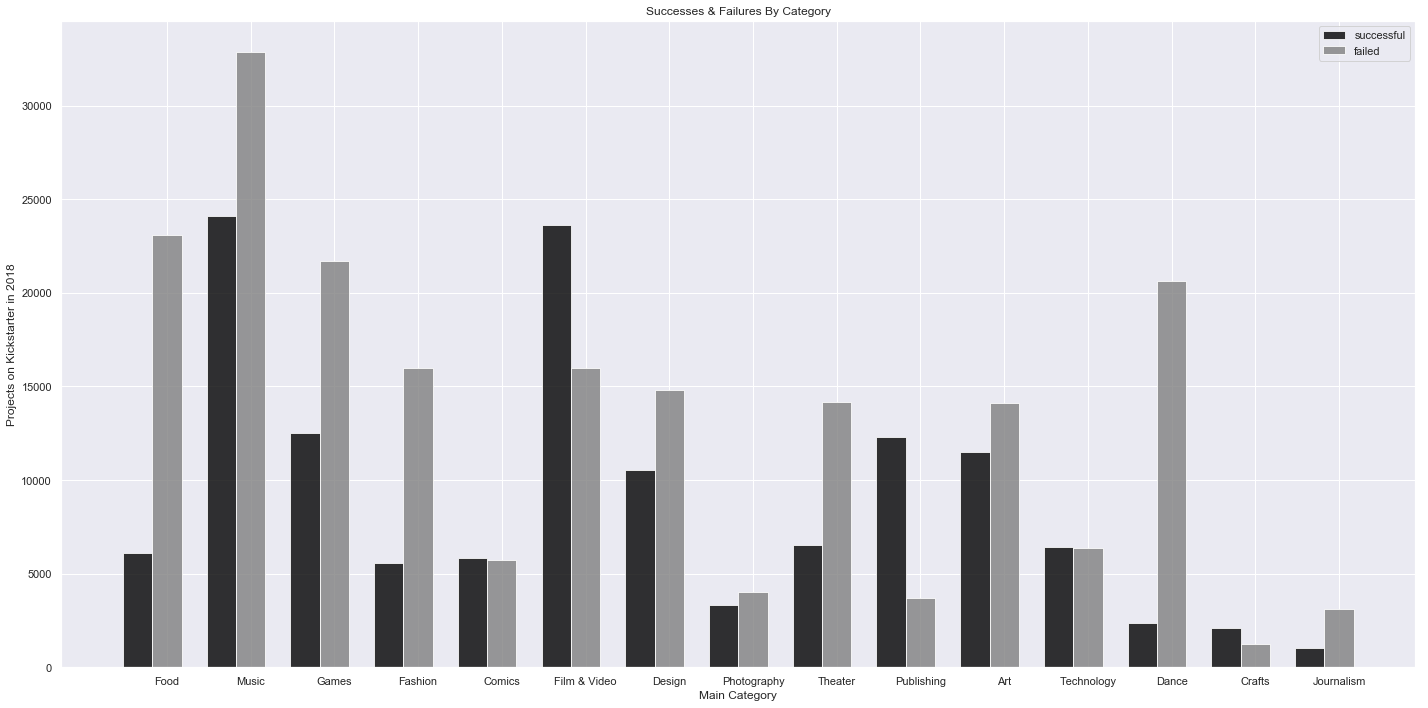

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = 15
successful = counts_s.values()
failed = counts_f.values()

# create plot
fig, ax = plt.subplots(figsize=(20,10))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, successful, bar_width,
alpha=opacity,
color='black',
label='successful')

rects2 = plt.bar(index + bar_width, failed, bar_width,
alpha=opacity,
color='grey',
label='failed')

plt.xlabel('Main Category')
plt.ylabel('Projects on Kickstarter in 2018')
plt.title('Successes & Failures By Category')
plt.xticks(index + bar_width, counts_s.keys())
plt.legend()

plt.tight_layout()
plt.show()


In [18]:
successes_tuples = [(key, value) for (key, value) in sorted(counts_s.items())]

In [19]:
failed_tuples = [(key, value) for (key, value) in sorted(counts_f.items())]

In [48]:
difference = []
for i in range(15):
    numerator = list(successes_tuples[i])[1]
    denominator = list(successes_tuples[i])[1] + list(failed_tuples[i])[1]
    temp = numerator/denominator
    difference.append(temp)


In [49]:
category_names = list(dict(successes_tuples).keys())

In [50]:
keys = category_names
values = difference
dictionary = dict(zip(keys, values))
print(dictionary)

{'Art': 0.44890795631825275, 'Comics': 0.5914152662482284, 'Crafts': 0.2705295471987721, 'Dance': 0.6543520850825637, 'Design': 0.41592082955486337, 'Fashion': 0.28284616162637805, 'Film & Video': 0.41788931561156045, 'Food': 0.2759136664550648, 'Games': 0.4389200561009818, 'Journalism': 0.24397299903567984, 'Music': 0.526298552433353, 'Photography': 0.3411084735266797, 'Publishing': 0.3473300765255697, 'Technology': 0.23785402647341566, 'Theater': 0.6379613356766256}


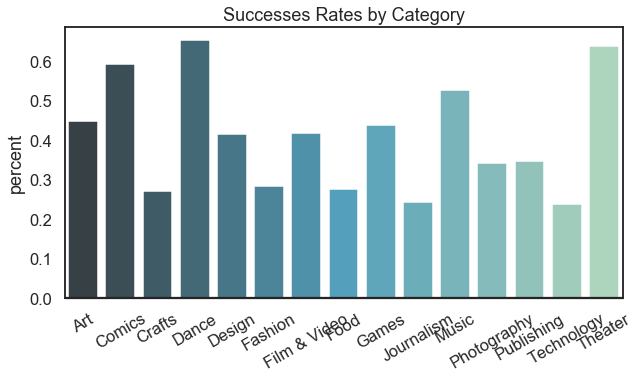

In [54]:
import matplotlib.pyplot as plt 

sns.set(style="white", context="talk")
f, ax1 = plt.subplots(figsize=(10,5))
# Generate some sequential data
x = category_names
y1 = difference
g = sns.barplot(x=x, y=y1, palette="GnBu_d")
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("percent")
g.set_xticklabels(g.get_xticklabels(), rotation=30)
plt.title('Successes Rates by Category')

label = ["{:.2%}".format(x) for x in difference]

In [107]:
main_category['usd_pledged_real'].sort_values(ascending=False)

main_category
Design          9614818.72
Games           8670429.17
Technology      6472520.75
Film & Video    1271860.77
Fashion         1216213.93
Publishing       938954.17
Music            549224.49
Art              449993.11
Food             340137.07
Photography      323265.07
Comics           281156.18
Crafts           197997.88
Journalism        31060.71
Dance             28459.20
Theater           16129.39
Name: usd_pledged_real, dtype: float64

## Data Preparation

The first thing we want to do is split our data into a training set and testing set. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_2018.drop("state", axis=1),
                                                    df_2018["state"],
                                                    test_size=0.25,
                                                    random_state=2019)


In [ ]:
y_train.value_counts(), y_test.value_counts()


In [ ]:
X_train.shape

Next we want to one hot encode our categorical variables. 

In [ ]:
encoder = OneHotEncoder(drop='first', categories="auto")
encoder.fit(X_train[["main_category", "country"]])

In [ ]:
encoder.categories_

In [ ]:
len(encoder.get_feature_names(['main_category', 'country']))

In [ ]:
encoder.transform(X_train[["main_category", "country"]])

In [ ]:
encoder.get_feature_names(["main_category", "country"])

In [ ]:
ohe = pd.DataFrame(encoder.transform(X_train[["main_category", "country"]]).toarray(),
                  columns=encoder.get_feature_names(["main_category", "country"]))


In [ ]:
X_train = X_train.reset_index(drop=True)

In [ ]:
X_train.head()

In [ ]:
X_train.shape

In [ ]:
ohe.shape

In [ ]:
y_train.shape

In [ ]:
X_train['launched_datetime'] = pd.to_datetime(X_train['launched'])
X_train['deadline_datetime'] = pd.to_datetime(X_train['deadline'])
X_train['project_times'] = pd.to_datetime(X_train['deadline']) - pd.to_datetime(X_train['launched'])
'''This extracts the project days from the total project time'''
X_train['project_length'] = X_train.project_times.dt.days

In [ ]:
X_train = X_train.drop(["category", "launched_datetime",'deadline_datetime',"main_category", "country", "name",
                       "currency", "launched", 'project_times',"backers", "pledged", "usd_pledged_real",
                       "usd pledged", "deadline"], axis=1)


In [ ]:
X_train2 = pd.concat(objs=[X_train, ohe], axis=1)

In [ ]:
X_train.shape, X_train2.shape, ohe.shape

## In the next section, we will use 6 different models to classify success. Then we will evaluate how they performed.  

### Model 1: Decision Tree Classifier

In [ ]:
X_train2.head()

In [ ]:
X_train2.shape

In [ ]:
clf = DecisionTreeClassifier(random_state=2019,
                             min_samples_leaf=30,
                             criterion="gini",
                             min_samples_split=2)

clf.fit(X_train2, y_train)

#### How well did our model do? 

In [ ]:
encoder = OneHotEncoder(drop='first', categories="auto")
encoder.fit(X_test[["main_category", "country"]])

In [ ]:
ohe = pd.DataFrame(encoder.transform(X_test[["main_category", "country"]]).toarray(),
                   columns=encoder.get_feature_names(["main_category", "country"]))
ohe.head()

In [ ]:
X_test = X_test.reset_index(drop=True)

In [ ]:
X_test['launched_datetime'] = pd.to_datetime(X_test['launched'])
X_test['deadline_datetime'] = pd.to_datetime(X_test['deadline'])
X_test['project_times'] = pd.to_datetime(X_test['deadline']) - pd.to_datetime(X_test['launched'])
'''This extracts the project days from the total project time'''
X_test['project_length'] = X_test.project_times.dt.days

In [ ]:
X_test = X_test.drop(["category", "launched_datetime",'deadline_datetime',"main_category", "country", "name",
                       "currency", "launched", 'project_times',"backers", "pledged", "usd_pledged_real",
                       "usd pledged", "deadline"], axis=1)

In [ ]:
X_test2 = pd.concat(objs=[X_test, ohe], axis=1)

In [ ]:
clf = DecisionTreeClassifier(random_state=2019,
                             min_samples_leaf=30,
                             criterion="gini",
                             min_samples_split=2)

clf.fit(X_test2, y_test)

In [ ]:
y_pred = clf.predict(X_test2)

In [ ]:
y_pred = pd.Series(y_pred)

In [ ]:
y_train = y_train.replace('successful', 1)
y_train = y_train.replace('failed', 0)

y_test = y_test.replace('successful', 1)
y_test = y_test.replace('failed', 0)

y_pred = y_pred.replace('successful', 1)
y_pred = y_pred.replace('failed', 0)

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

# Calculate Accuracy 
acc = accuracy_score(y_test,y_pred) * 100
print("Accuracy is :{0}".format(acc))

# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("\nAUC is :{0}".format(round(roc_auc,2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

#### Optimizing Model 1

Now we will prune our decision tree using the following parameters:

* Maximum Depth: Reduce the depth of the tree to build a generalized tree. 

* Minimum Samples Leaf with Split: Restrict the size of sample leaf

* Minimum Leaf Sample Size: Size in terminal nodes can be fixed to 30, 100, 300 or 5% of total

* Maximum Leaf Nodes: Reduce the number of leaf nodes

* Maximum Features: Maximum number of features to consider when splitting a node

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [ ]:
# Identify the optimal tree depth for given data
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
   dt.fit(X_train2, y_train)
   train_pred = dt.predict(X_train2)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test2)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)
plt.figure(figsize=(12,6))
plt.plot(max_depths, train_results, 'b', label='Train AUC')
plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.legend()
plt.show()

In [ ]:
# Identify the optimal min-samples-split for given data
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=min_samples_split)
   dt.fit(X_train2, y_train)
   train_pred = dt.predict(X_train2)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test2)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
plt.figure(figsize=(12,6))
plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.xlabel('Min. Sample splits')
plt.legend()
plt.show()

In [ ]:
# Calculate the optimal value for minimum sample leafs

min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=min_samples_leaf)
   dt.fit(X_train2, y_train)
   train_pred = dt.predict(X_train2)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test2)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    

plt.figure(figsize=(12,6))    
plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Min. Sample Leafs')
plt.legend()
plt.show()    

In [ ]:
# Find the best value for optimal maximum feature size
max_features = list(range(1,X_train2.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
   dt = DecisionTreeClassifier(criterion='entropy', max_features=max_feature)
   dt.fit(X_train2, y_train)
   train_pred = dt.predict(X_train2)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test2)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

    
plt.figure(figsize=(12,6))
plt.plot(max_features, train_results, 'b', label='Train AUC')
plt.plot(max_features, test_results, 'r', label='Test AUC')

plt.ylabel('AUC score')
plt.xlabel('max features')
plt.legend()
plt.show()   

In [ ]:
# train a classifier with optimal values identified above
dt = DecisionTreeClassifier(criterion='entropy',
                           max_features=4,
                           max_depth=7,
                           min_samples_split=0.8,
                           min_samples_leaf=0.4)
dt.fit(X_train2, y_train)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

### Models 2-3: Random Forest Ensemble Method and XGBoost

Build a bagged tree.

In [ ]:
from sklearn.ensemble import BaggingClassifier

In [1]:
#Observe how long it will take to run our classifier 
from datetime import datetime
startTime = datetime.now()

#do something
bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=7), n_estimators=20)
bagged_tree.fit(X_train2, y_train)
print(datetime.now() - startTime)

NameError: name 'BaggingClassifier' is not defined

In [ ]:
bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=7), n_estimators=20)
bagged_tree.fit(X_train2, y_train)

In [ ]:
print(bagged_tree.score(X_train2, y_train))
print(bagged_tree.score(X_test2, y_test))

Build a random forest.

In [ ]:
from sklearn.ensemble import RandomForestClassifier


In [ ]:
#Observe how long it will take to run our classifier 
from datetime import datetime
startTime = datetime.now()

#do something
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(X_train2, y_train)
print(datetime.now() - startTime)

In [ ]:
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(X_train2, y_train)

In [ ]:
forest.score(X_test2, y_test)


In [ ]:
from sklearn.metrics import roc_curve, auc

#First calculate the probability scores of each of the datapoints:
forest.fit(X_train2, y_train)

In [ ]:
y_score = forest.predict_proba(X_test2)[:, 1]

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_score)

Use XG Boost 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Model 4: Logistic Regression

### Model 5-6: Adaboost Classifier and Gradient Boosting Classifier 

In [ ]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [ ]:
adaboost_clf = AdaBoostClassifier()
gbt_clf = GradientBoostingClassifier()

In [ ]:
from datetime import datetime
startTime = datetime.now()

#do something
adaboost_clf.fit(X_train2, y_train)
print(datetime.now() - startTime)

In [ ]:
from datetime import datetime
startTime = datetime.now()

#do something
gbt_clf.fit(X_train2, y_train)
print(datetime.now() - startTime)

In [ ]:
adaboost_clf.fit(X_train2, y_train)

In [ ]:
gbt_clf.fit(X_train2, y_train)

In [ ]:
adaboost_train_preds = adaboost_clf.predict(X_train2)
adaboost_test_preds = adaboost_clf.predict(X_test2)
gbt_clf_train_preds = gbt_clf.predict(X_train2)
gbt_clf_test_preds = gbt_clf.predict(X_test2)

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
def display_acc_and_f1_score(true, preds, model_name):
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds)
    print("Model: {}".format(model_name))
    print("Accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))
    
print("Training Metrics")
display_acc_and_f1_score(y_train, adaboost_train_preds, model_name='AdaBoost')
print("")
display_acc_and_f1_score(y_train, gbt_clf_train_preds, model_name='Gradient Boosted Trees')
print("")
print("Testing Metrics")
display_acc_and_f1_score(y_test, adaboost_test_preds, model_name='AdaBoost')
print("")
display_acc_and_f1_score(y_test, gbt_clf_test_preds, model_name='Gradient Boosted Trees')

In [ ]:
adaboost_confusion_matrix = confusion_matrix(y_test, adaboost_test_preds)
adaboost_confusion_matrix

In [ ]:
gbt_confusion_matrix = confusion_matrix(y_test, gbt_clf_test_preds)
gbt_confusion_matrix

In [ ]:
adaboost_classification_report = classification_report(y_test, adaboost_test_preds)
print(adaboost_classification_report)

In [ ]:
gbt_classification_report = classification_report(y_test, gbt_clf_test_preds)
print(gbt_classification_report)

## Evaluating Model Performance

"If the cost of having False negative is high, we want to increase the model sensitivity and recall. If the cost of having False positive is high, then we want to increase the model specificity and precision" 

In our case, a false negative looks like a project that would do well on kickstarter but we classified as failing and a false positive looks like a project that would fail on kickstarter but we classified it as successful.

Depending on the opportunity cost for the project owner, we may value giving a conservative prediction more than taking a chance that we have a false negative. 

#### Priciple Component Analysis 

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
ss = StandardScaler()
scaled_data = ss.fit_transform(X_train2)

In [ ]:
scaled_df = pd.DataFrame(data=scaled_data)

In [ ]:
pca = PCA(n_components=2)
#pca_data = pca.fit_transform(scaled_df)
pca_data = pca.fit_transform(scaled_df)

pca_df = pd.DataFrame(data=pca_data, columns=['pca1','pca2'])

In [ ]:
model= KMeans(n_clusters=4, random_state=2019).fit(pca_df)
model_label = model.labels_
model_centers= model.cluster_centers_

fig = plt.figure(figsize=(12,15))
ax = fig.add_subplot(111)
scatter = ax.scatter(pca_df['pca1'],pca_df['pca2'],
                    c=model_label,s=50)
ax.set_title("K-Means Clustering")
ax.set_xlabel('pca1')
ax.set_ylabel('pca2')
plt.colorbar(scatter)
plt.scatter(model_centers[:,0],model_centers[:,1],c='red',marker='*')

In [ ]:
pca_component_df = pd.DataFrame(pca.components_)

In [ ]:
pca_component_df.head()

In [ ]:
pca_c_df = pca_component_df.T 

In [ ]:
pca_c_df.columns = ['pca1','pca2']


In [ ]:
pca_c_df.head()

In [ ]:
pca_c_df['pca1'].sort_values(ascending=False).head(5)

In [ ]:
pca_c_df['pca2'].sort_values(ascending=False).head(5)

In [ ]:
pca.explained_variance_

In [ ]:
pca2= PCA(.90)
pca2.fit(scaled_df)

In [ ]:
pca2.n_components_

In [ ]:
X_train2.shape

In [ ]:
np.sort(pca.components_[0])

In [ ]:
for pca in pca.components_:
    print(np.amax(pca),np.argmax(pca))

In [ ]:
np.amax(pca.components_[0]),np.argmax(pca.components_[0])

In [ ]:
def max(arr):
    max_ = arr[0]
    for item in arr:
        if item > max_:
            max_ = item
    return max_  

In [ ]:
sorted(list(pca.components_[0]),reverse=True)

In [ ]:
pca.components_[0]

In [ ]:
sorted(list(pca.components_[1]),reverse=True)

In [ ]:
pca.components_[1]

In [ ]:
df_2018_concat.head()

In [ ]:
predictors, target = (df_2018_concat.drop("state", axis=1),df_2018_concat["state"])

In [ ]:
classifiers = [DecisionTreeClassifier(), RandomForestClassifier(n_estimators=100, max_depth=5), 
               GradientBoostingClassifier(n_estimators=100), xgb.XGBClassifier()]